#Requirements + Loading

In [ ]:
!pip install -q ffmpeg transformers torch
!pip install --upgrade transformers torch pillow numpy scikit-learn
!pip install tqdm

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 92.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 97.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 92.1 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.3.0
    Uninstalling triton-2.3.0:
      Successfully uninstalled triton-2.3.0
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstal

In [ ]:
import cv2
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import pickle
from tqdm.notebook import tqdm
import logging
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
checkpoint_file = '/content/drive/MyDrive/Embeddings/checkpoint01.pkl'

with open(checkpoint_file, 'rb') as f:
    checkpoint_data = pickle.load(f)
allembeddings = checkpoint_data['all_embeddings']
print(allembeddings[0]['embedding'])

[[-1.84985716e-02 -1.05844252e-02  1.25856465e-02  2.44779326e-02
   1.62170790e-02 -8.05383362e-03 -3.12641226e-02 -3.06126885e-02
   8.66407380e-02  2.02781260e-02  2.12268904e-02  2.90397648e-02
   4.71502496e-03 -1.49114374e-02 -4.22102399e-02  8.91140720e-04
  -1.35010675e-01  3.01825888e-02  2.69549210e-02 -2.38687615e-03
  -2.43746000e-03 -4.33101095e-02 -3.11755650e-02  4.82879579e-03
  -4.14470360e-02 -2.03904938e-02 -3.09576206e-02 -1.88604891e-02
   1.59741882e-02  2.89305542e-02  1.05259242e-02  6.73916191e-03
  -1.60544906e-02  2.25112382e-02  5.26779778e-02  1.29903678e-03
  -2.16459911e-02 -4.04966250e-03 -7.54726958e-03  7.59792924e-02
  -3.86645459e-02 -1.17044980e-02 -7.01767066e-03 -1.29440622e-02
  -1.84128676e-02  1.29513323e-01  3.41233355e-03  2.62953099e-02
   5.50103374e-02  5.56821302e-02  8.65582936e-03 -8.47416930e-03
   1.70306731e-02  1.78283565e-02 -3.70086096e-02 -1.80872977e-02
  -1.32025834e-02 -1.65056810e-02  2.93437168e-02  5.18253744e-02
  -1.05308

In [ ]:
len(allembeddings)

219959

#Embed

In [ ]:
def pad_to_square(image):
    width, height = image.size
    max_side = max(width, height)
    left = (max_side - width) // 2
    top = (max_side - height) // 2
    right = max_side - width - left
    bottom = max_side - height - top
    padding = (left, top, right, bottom)
    return transforms.functional.pad(image, padding, fill=0, padding_mode='constant')

# Define the modified preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Lambda(pad_to_square),  # Pad the image to make it square
    transforms.Resize((224, 224)),     # Resize the padded image to 224x224
    transforms.ToTensor(),             # Convert the image to a PyTorch tensor
    transforms.Normalize(              # Normalize the tensor using ImageNet's mean and std
        mean=[0.48145466, 0.4578275, 0.40821073],
        std=[0.26862954, 0.26130258, 0.27577711]
    ),
])

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def preprocess_and_embed(image, processor=preprocess, model=model):
    try:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        preprocessed_image = processor(image).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = model.get_image_features(preprocessed_image)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        return image_features.cpu().numpy()
    except Exception as e:
        print(f"Error preprocessing and embedding image: {e}")
        return None




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

#Search by image (frame) OR text

In [ ]:
import subprocess

input_video = '/content/drive/MyDrive/COPY/VOL00001/NATIVES/NATIVE00001/CCRB-00001679.MOV'
output_image = 'randoframe.png'

# Extract the fifth frame
command = [
    'ffmpeg',
    '-i', input_video,
    '-vf', 'select=eq(n\\,4)',  # Select the fifth frame (0-indexed, so 4 is the fifth frame)
    '-vsync', 'vfr',
    '-q:v', '2',
    output_image
]

subprocess.run(command)


CompletedProcess(args=['ffmpeg', '-i', '/content/drive/MyDrive/COPY/VOL00001/NATIVES/NATIVE00001/CCRB-00001679.MOV', '-vf', 'select=eq(n\\,4)', '-vsync', 'vfr', '-q:v', '2', 'randoframe.png'], returncode=0)

In [ ]:
#embed text
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def preprocess_and_embed_text(text, processor=processor, model=model):
    try:
        inputs = processor(text=[text], return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            text_features = model.get_text_features(**inputs)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        return text_features.cpu().numpy()
    except Exception as e:
        print(f"Error preprocessing and embedding text: {e}")
        return None


text1 = "aerial"
text2 = "bodycam"
aerial_shot = preprocess_and_embed_text(text1)
bodycam_footage = preprocess_and_embed_text(text2)

text4 = "police brutality"
brutality = preprocess_and_embed_text(text4)


In [ ]:
search_embedding = []

frame = cv2.imread('/content/randoframe.png')

video_path = 'test'
frame_idx = 5

embedding = preprocess_and_embed(frame)
search_embedding.append({
    'video_path': video_path,
    'frame_number': frame_idx,
    'embedding': embedding
})



Error preprocessing and embedding image: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



In [ ]:
search_embedding = brutality

In [ ]:
#Cosine sim search

import numpy as np

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def find_top_k_similar_embeddings(embedding, allembeddings, k=10):
    similarities = []
    for item in allembeddings:
        other_embedding = item['embedding'][0]  # Extract the embedding
        similarity = cosine_similarity(embedding, other_embedding)
        similarities.append((item['video_path'], item['frame_number'], similarity))

    # Sort by similarity in descending order and get top k
    similarities.sort(key=lambda x: x[2], reverse=True)
    top_k_similarities = similarities[:k]

    return top_k_similarities

def find_similar_embeddings_above_threshold(embedding, allembeddings, threshold=0.8):
    similar_embeddings = []
    for item in allembeddings:
        other_embedding = item['embedding'][0]  # Extract the embedding
        similarity = cosine_similarity(embedding, other_embedding)
        if similarity >= threshold:
            similar_embeddings.append((item['video_path'], item['frame_number'], similarity))

    # Sort by similarity in descending order
    similar_embeddings.sort(key=lambda x: x[2], reverse=True)

    return similar_embeddings



In [ ]:
#average over frames of video
from collections import defaultdict


def average_similarities_over_videos(vector1, vector2, allembeddings):
    similarities1 = defaultdict(list)
    similarities2 = defaultdict(list)

    for item in allembeddings:
        other_embedding = item['embedding'][0]  # Extract the embedding
        similarity1 = cosine_similarity(vector1, other_embedding)
        similarity2 = cosine_similarity(vector2, other_embedding)

        video_path = item['video_path']
        similarities1[video_path].append(similarity1)
        similarities2[video_path].append(similarity2)

    average_similarities = []
    for video_path in similarities1.keys():
        avg_similarity1 = np.mean(similarities1[video_path])
        avg_similarity2 = np.mean(similarities2[video_path])
        average_similarities.append((video_path, avg_similarity1, avg_similarity2))

    return average_similarities


In [ ]:
average_similarities = average_similarities_over_videos(aerial_shot, bodycam_footage, allembeddings)

In [ ]:
top_10_similar = find_top_k_similar_embeddings(search_embedding, allembeddings, 10)


In [ ]:
print(top_10_similar)

[('/content/drive/MyDrive/COPY/VOL00001/NATIVES/NATIVE00001/NYPD-0000114529.MOV', 0, array([0.32395685], dtype=float32)), ('/content/drive/MyDrive/COPY/VOL00001/NATIVES/NATIVE00001/Incidents-00000579.MP4', 15, array([0.32198393], dtype=float32)), ('/content/drive/MyDrive/COPY/VOL00001/NATIVES/NATIVE00001/Incidents-00000579.MP4', 45, array([0.32037082], dtype=float32)), ('/content/drive/MyDrive/COPY/VOL00001/NATIVES/NATIVE00001/Incidents-00000864.MP4', 60, array([0.3203445], dtype=float32)), ('/content/drive/MyDrive/COPY/VOL00001/NATIVES/NATIVE00001/Incidents-00000579.MP4', 0, array([0.3200494], dtype=float32)), ('/content/drive/MyDrive/COPY/VOL00001/NATIVES/NATIVE00001/Incidents-00000163.MOV', 540, array([0.31893125], dtype=float32)), ('/content/drive/MyDrive/COPY/VOL00001/NATIVES/NATIVE00001/Incidents-00002572.0001.MOV', 1470, array([0.31748793], dtype=float32)), ('/content/drive/MyDrive/COPY/VOL00001/NATIVES/NATIVE00001/NYPD-0000114529.MOV', 180, array([0.31735668], dtype=float32)), 

In [ ]:
similarbatch = find_similar_embeddings_above_threshold(search_embedding, allembeddings, threshold=0.8)

In [ ]:
from collections import defaultdict

def count_unique_video_paths(similar_embeddings):
    video_path_counts = defaultdict(int)
    for video_path, frame_number, similarity in similar_embeddings:
        video_path_counts[video_path] += 1
    return dict(video_path_counts)

uniquevideos = count_unique_video_paths(similarbatch)

In [ ]:
print(len(uniquevideos))

285


In [ ]:
def display_frames_grid(results):
    num_results = len(results)
    grid_size = int(np.ceil(np.sqrt(num_results)))

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axes = axes.flatten()

    for ax, (video_path, frame_number, similarity) in zip(axes, results):
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            print(f"Error opening video stream or file: {video_path}")
            continue

        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()

        if ret:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            ax.imshow(frame_rgb)

            file_name = os.path.basename(video_path)

            ax.set_title(f"{file_name}\nFrame: {frame_number}\nSimilarity: {similarity[0]:.4f}")
            ax.axis('off')
        else:
            print(f"Error reading frame {frame_number} from video: {video_path}")
            ax.axis('off')

        cap.release()

    for ax in axes[num_results:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


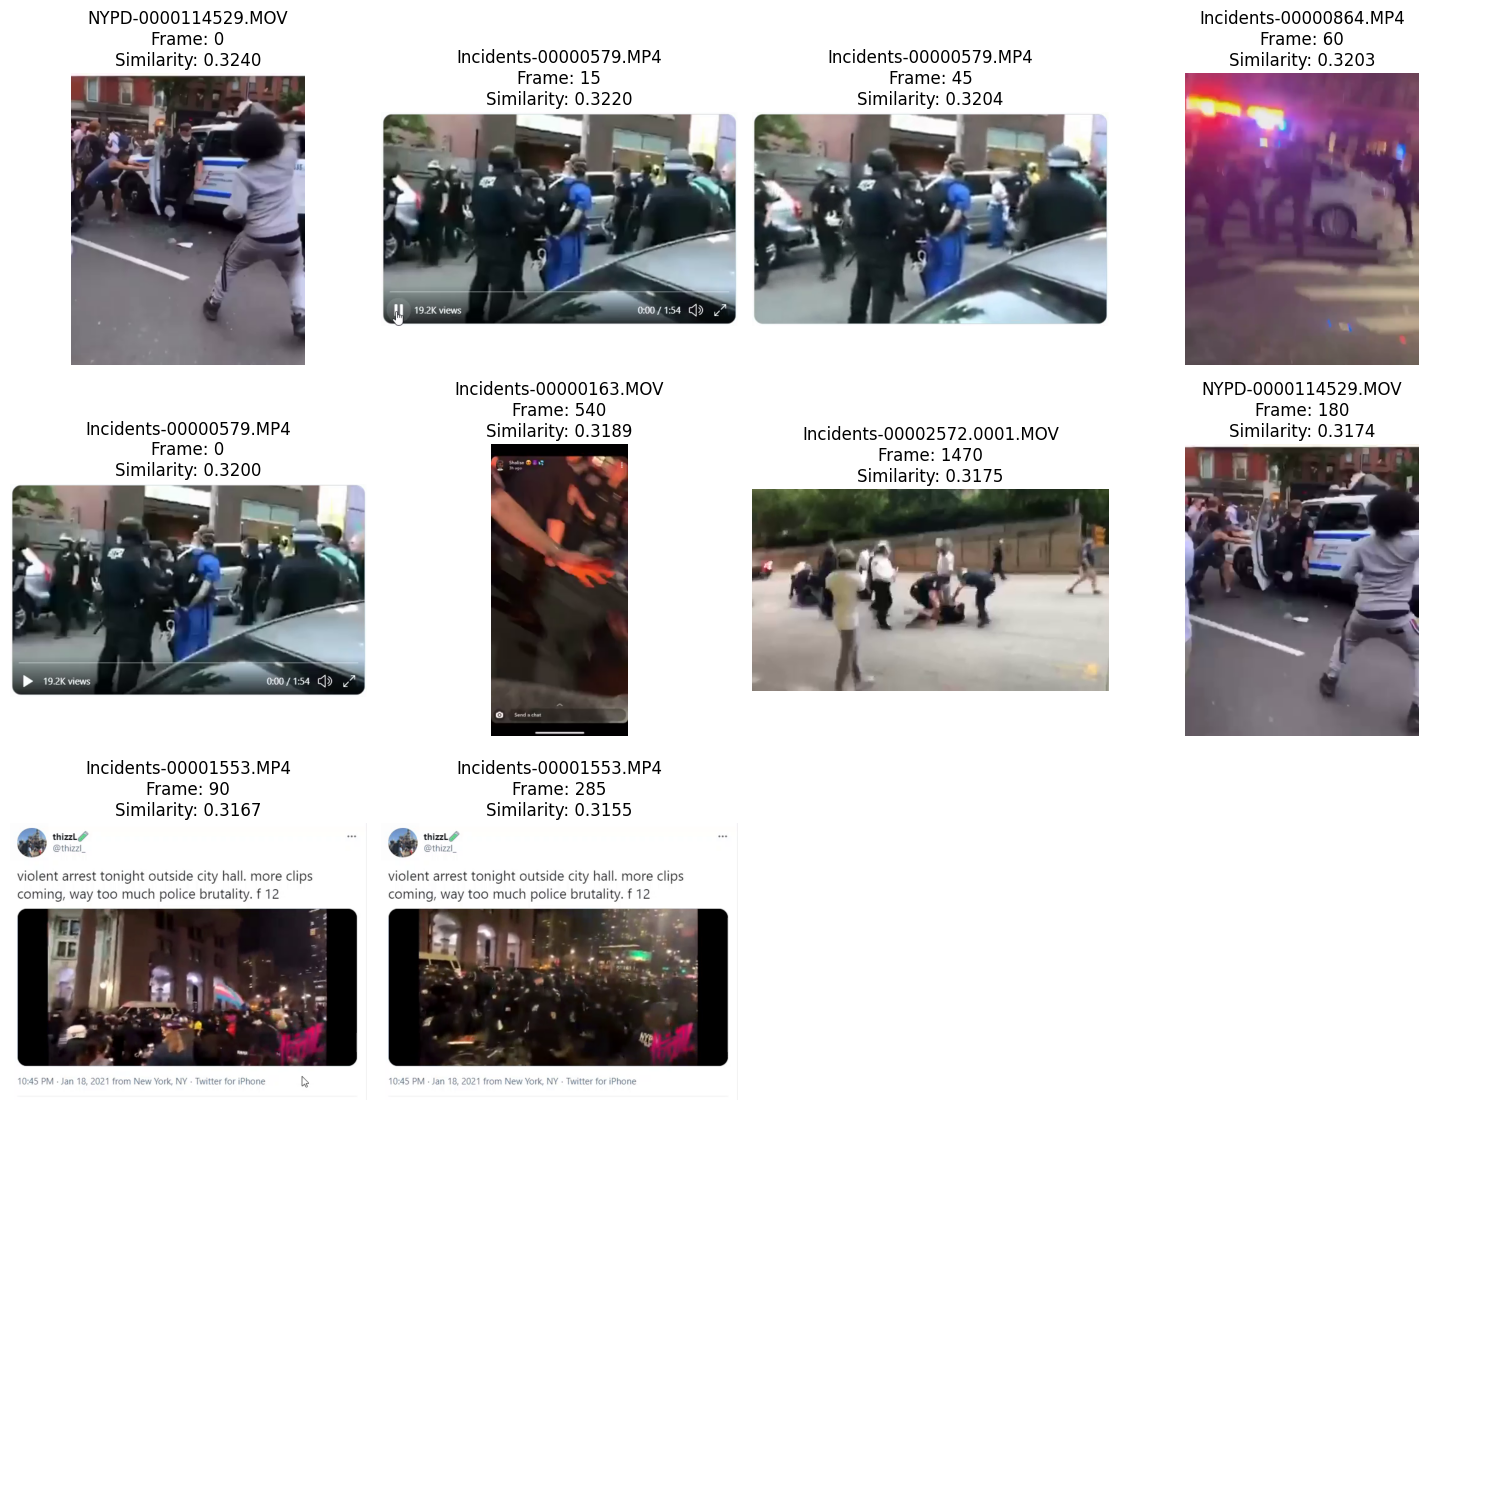

In [ ]:
display_frames_grid(top_10_similar)

# Look up videos by proximity to category (word) embedding "aerial" and "body cam" and save top 100 videos

In [ ]:
def add_embeddings_to_results(results, allembeddings):
    # Create a dictionary for quick lookup of embeddings by video path and frame number
    embedding_lookup = {
        (item['video_path'], item['frame_number']): item['embedding']
        for item in allembeddings
    }

    # Add embeddings to the results list
    updated_results = []
    for video_path, frame_number, similarity in results:
        embedding = embedding_lookup.get((video_path, frame_number))
        updated_results.append((video_path, frame_number, similarity, embedding))

    return updated_results



In [ ]:
similarbatchdrtest = add_embeddings_to_results(top_10_similar, allembeddings)

data_array = np.array(similarbatchdrtest, dtype=object)

np.save('/content/drive/MyDrive/PLOT/textcat/top100bodycam.npy', data_array)


In [ ]:
#similarbatchdrtest = np.load('/content/drive/MyDrive/PLOT/top100frame1/f1top100.npy', allow_pickle=True)


#Visualize top 100 batches with T-SNE

In [ ]:
bodycamnp =  np.load('/content/drive/MyDrive/PLOT/textcat/top100bodycam.npy', allow_pickle=True)
aerialnp =  np.load('/content/drive/MyDrive/PLOT/textcat/top100aerial.npy', allow_pickle=True)


In [ ]:
concat_np = []
concat_np.append(['aerial shot', 0, 0, np.array(aerial_shot), 'searchv1'])
concat_np.append(['bodycam footage', 0, 0, np.array(bodycam_footage), 'searchv2'])

for item in aerialnp:
    item_list = item.tolist()
    # Append the new element
    item_list.append('resultsv1')
    # Convert back to a NumPy array with dtype=object
    new_item = np.array(item_list, dtype=object)
    concat_np.append(new_item)
for item in bodycamnp:
    item_list = item.tolist()
    # Append the new element
    item_list.append('resultsv2')
    # Convert back to a NumPy array with dtype=object
    new_item = np.array(item_list, dtype=object)
    concat_np.append(new_item)




In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

# Load the embeddings from the npy file
embeddings_array = concat_np#similarbatchdrtest

image_names = []
embeddings = []
vtypes = []

for item in embeddings_array:
    video_path, frame_number, similarity, embedding, vtype = item
    sanitized_video_path = video_path.replace('/', '_')
    image_name = f"{sanitized_video_path}_frame_{frame_number}.jpg"
    image_names.append(image_name)
    vtypes.append(vtype)
    # Ensure embedding is a NumPy array
    if isinstance(embedding, torch.Tensor):
        embedding = embedding.cpu().numpy()
    embeddings.append(np.array(embedding))

embeddings = np.vstack(embeddings)
n_samples = len(embeddings)
print(n_samples)
perplexity = min(30, n_samples - 1)  # Set perplexity to a value less than the number of samples

# t-SNE to reduce dimensionality to 2 components
tsne = TSNE(n_components=2, random_state=0, perplexity=55)
projections = tsne.fit_transform(embeddings)

df = pd.DataFrame(projections, columns=['x', 'y'])
df['image_name'] = image_names
df['vtype'] = vtypes




202


In [ ]:
import plotly.graph_objs as go

import base64
import io


colors = ['red' if i < 2 else 'blue' for i in range(len(df))]

fig = go.Figure(data=go.Scattergl(
    x = df['x'],
    y = df['y'],
    mode='markers',
    marker=dict(
        color=colors,
        line_width=0.1
    )
))

fig.show(renderer = "colab")


In [ ]:
csv_file_path = '/content/textcattest2.csv'
df.to_csv(csv_file_path, index=False)

#Save images

In [ ]:
import os
import cv2
from tqdm import tqdm

def resize_and_pad(image, target_size=512):
    h, w, _ = image.shape
    # Determine the scaling factor to resize the image
    scale_factor = target_size / max(h, w)
    # Resize the image
    new_w = int(w * scale_factor)
    new_h = int(h * scale_factor)
    resized_image = cv2.resize(image, (new_w, new_h))
    # Calculate padding values to center the image
    pad_w = (target_size - new_w) // 2
    pad_h = (target_size - new_h) // 2
    # Create a new image with padding
    padded_image = cv2.copyMakeBorder(
        resized_image,
        pad_h,
        target_size - new_h - pad_h,
        pad_w,
        target_size - new_w - pad_w,
        cv2.BORDER_CONSTANT,
        value=[0, 0, 0]
    )
    return padded_image

def save_frames_and_results(results, output_folder, target_size=512):
    # Ensure output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for idx, (video_path, frame_number, similarity, embedding, vtype) in tqdm(enumerate(results), total=len(results), desc="Processing videos"):
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            print(f"Error opening video stream or file: {video_path}")
            continue

        # Set the frame position
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

        # Read the frame
        ret, frame = cap.read()

        if ret:
            try:
                # Resize and pad the image
                padded_frame = resize_and_pad(frame, target_size)

                # Construct image file name
                sanitized_video_path = video_path.replace('/', '_')
                image_name = f"{sanitized_video_path}_frame_{frame_number}.jpg"
                image_path = os.path.join(output_folder, image_name)

                # Save the padded frame as an image
                cv2.imwrite(image_path, padded_frame)

            except Exception as e:
                print(f"Error saving frame {frame_number} from video: {video_path}. Error: {e}")
        else:
            print(f"Error reading frame {frame_number} from video: {video_path}")

        cap.release()

    return




In [ ]:
output_folder = '/content/drive/MyDrive/PLOT/textcat/imgs'
save_frames_and_results(concat_np, output_folder)

Processing videos:   2%|▏         | 4/202 [00:00<00:07, 27.44it/s]

Error opening video stream or file: aerial shot
Error opening video stream or file: bodycam footage


Processing videos: 100%|██████████| 202/202 [03:05<00:00,  1.09it/s]


In [ ]:
from tqdm import tqdm

def save_frames_and_results(results, output_folder):
    # Ensure output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for idx, (video_path, frame_number, similarity) in tqdm(enumerate(results), total=len(results), desc="Processing videos"):
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            print(f"Error opening video stream or file: {video_path}")
            continue

        # Set the frame position
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

        # Read the frame
        ret, frame = cap.read()

        if ret:
            try:
                # Construct image file name
                sanitized_video_path = video_path.replace('/', '_')

                image_name = f"{sanitized_video_path}_frame_{frame_number}.jpg"
                image_path = os.path.join(output_folder, image_name)

                # Save the frame as an image
                cv2.imwrite(image_path, frame)

            except Exception as e:
                print(f"Error saving frame {frame_number} from video: {video_path}. Error: {e}")
        else:
            print(f"Error reading frame {frame_number} from video: {video_path}")

        cap.release()

    return


In [ ]:
output_folder = '/content/drive/MyDrive/PLOT/top100frame1/imgs'
save_frames_and_results(similarbatch, output_folder)

Processing videos:  10%|▉         | 449/4589 [03:10<29:55,  2.31it/s]

Error reading frame 74704 from video: /content/drive/MyDrive/COPY/VOL00001/NATIVES/NATIVE00001/NYPD-0000072100.MP4


Processing videos:  63%|██████▎   | 2883/4589 [37:01<05:51,  4.86it/s]

Error reading frame 74994 from video: /content/drive/MyDrive/COPY/VOL00001/NATIVES/NATIVE00001/NYPD-0000072099.MP4


Processing videos:  79%|███████▊  | 3612/4589 [53:30<9:33:50, 35.24s/it]

Error reading frame 123600 from video: /content/drive/MyDrive/COPY/VOL00001/NATIVES/NATIVE00001/Incidents-00000076.MOV


Processing videos:  99%|█████████▉| 4562/4589 [1:13:48<21:19, 47.38s/it]

Error reading frame 91050 from video: /content/drive/MyDrive/COPY/VOL00001/NATIVES/NATIVE00001/Incidents-00000076.MOV


Processing videos: 100%|██████████| 4589/4589 [1:14:00<00:00,  1.03it/s]


In [ ]:
import os
import cv2
import numpy as np

def resize_and_pad(image, target_size=512):
    h, w, _ = image.shape
    # Determine the scaling factor to resize the image
    scale_factor = target_size / max(h, w)
    # Resize the image
    new_w = int(w * scale_factor)
    new_h = int(h * scale_factor)
    resized_image = cv2.resize(image, (new_w, new_h))
    # Calculate padding values to center the image
    pad_w = (target_size - new_w) // 2
    pad_h = (target_size - new_h) // 2
    # Create a new image with padding
    padded_image = cv2.copyMakeBorder(
        resized_image,
        pad_h,
        target_size - new_h - pad_h,
        pad_w,
        target_size - new_w - pad_w,
        cv2.BORDER_CONSTANT,
        value=[0, 0, 0]
    )
    return padded_image

def process_images_in_folder(input_folder, output_folder=None, target_size=512):
    if output_folder is None:
        output_folder = input_folder

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            image = cv2.imread(input_path)
            if image is not None:
                resized_padded_image = resize_and_pad(image, target_size)
                cv2.imwrite(output_path, resized_padded_image)
                print(f"Processed and saved: {output_path}")
            else:
                print(f"Failed to read: {input_path}")

# Example usage
input_folder = '/content/drive/MyDrive/PLOT/top100frame1/imgs'
output_folder = '/content/drive/MyDrive/PLOT/top100frame1/imgresized'  # Optional, can be the same as input_folder
process_images_in_folder(input_folder, output_folder)


Processed and saved: /content/drive/MyDrive/PLOT/top100frame1/imgresized/_content_drive_MyDrive_COPY_VOL00001_NATIVES_NATIVE00001_NYPD-0000072104.MP4_frame_10063.jpg
Processed and saved: /content/drive/MyDrive/PLOT/top100frame1/imgresized/_content_drive_MyDrive_COPY_VOL00001_NATIVES_NATIVE00001_NYPD-0000113516.MP4_frame_10324.jpg
Processed and saved: /content/drive/MyDrive/PLOT/top100frame1/imgresized/_content_drive_MyDrive_COPY_VOL00001_NATIVES_NATIVE00001_NYPD-0000072104.MP4_frame_6467.jpg
Processed and saved: /content/drive/MyDrive/PLOT/top100frame1/imgresized/_content_drive_MyDrive_COPY_VOL00001_NATIVES_NATIVE00001_NYPD-0000070442.MP4_frame_4756.jpg
Processed and saved: /content/drive/MyDrive/PLOT/top100frame1/imgresized/_content_drive_MyDrive_COPY_VOL00001_NATIVES_NATIVE00001_NYPD-0000076668.MP4_frame_4756.jpg
Processed and saved: /content/drive/MyDrive/PLOT/top100frame1/imgresized/_content_drive_MyDrive_COPY_VOL00001_NATIVES_NATIVE00001_Incidents-00001376.MP4_frame_4756.jpg
Proce

#Create video category embeddings for the categories "aerial", "body cam", and "user generated content" by averaging a sample set of each type of video and sort a batch of videos by proximity to these example embeddings.  

In [ ]:
!pip install gspread oauth2client


In [ ]:
import gspread
from google.colab import auth
import pandas as pd
import os
import shutil
from datetime import datetime

auth.authenticate_user()
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

spreadsheet_name = "Copy of NLG x SITU > AV Database"
sheet = gc.open(spreadsheet_name)#.sheet1
new_gsheet = sheet.get_worksheet(0)
old_gsheet = sheet.get_worksheet(1)
new_data = new_gsheet.get_all_values()
old_data = old_gsheet.get_all_values()

new_headers = new_data[0]  # first row is header
new_rows = new_data[1:]
new_sheet = pd.DataFrame(new_rows, columns=new_headers)

old_headers = old_data[0]
old_rows = old_data[1:]
old_sheet = pd.DataFrame(old_rows, columns=old_headers)


In [ ]:
new_sheet['FILENAME'] = old_sheet['FILENAME']
new_sheet['FULLPATH'] = old_sheet['FULLPATH']
new_sheet['MEDIA TYPE'] = old_sheet['MEDIA TYPE']
def modify_path(fullpath):
    return '/content/drive/MyDrive/COPY/' + '/'.join(fullpath.split('/')[2:])

# Apply the function to the 'FULLPATH' column and create a new column
new_sheet['MODIFIED_PATH'] = old_sheet['FULLPATH'].apply(modify_path)


In [ ]:
media_types = ['AVIATION', 'UGC', 'BODY CAM']
video_formats = ('.mp4', '.mov', '.avi', '.mkv', '.wmv')


def modify_path(fullpath):
    return '/content/drive/MyDrive/COPY/' + '/'.join(fullpath.split('/')[2:])

selected_paths = {}
for media_type in media_types:
    filtered_sheet = old_sheet[old_sheet['MEDIA TYPE'] == media_type]
    #filtered_sheet = filtered_sheet[filtered_sheet['FULLPATH']]#.str[-4:].str.lower().isin(video_formats)]
    print(media_type + ': ' + str(len(filtered_sheet)))
    sampled_df = filtered_sheet.sample(n=min(200, len(filtered_sheet)), random_state=1333)
    modified_paths = sampled_df['FULLPATH'].apply(modify_path).tolist()
    selected_paths[media_type] = modified_paths

copy_path = '/content/drive/MyDrive/COPY'

def display_first_frame(video_path, media_type):
    full_video_path = os.path.join(copy_path, *video_path.split('/')[5:])
    if not os.path.exists(full_video_path):
        print(f"File not found: {full_video_path}")
        return None

    cap = cv2.VideoCapture(full_video_path)
    ret, frame = cap.read()
    cap.release()

    if ret:
        plt.figure()
        plt.title(f"Media Type: {media_type}")
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    else:
        print(f"Could not read frame from {full_video_path}")




AVIATION: 227
UGC: 1039
BODY CAM: 3714


In [ ]:
print(selected_paths)

{'AVIATION': ['/content/drive/MyDrive/COPY/VOL00008/NATIVES/NATIVE00001/NYPD_N_00000655.G64', '/content/drive/MyDrive/COPY/VOL00007/NATIVES/NATIVE00001/NYPD_N_00000629.G64', '/content/drive/MyDrive/COPY/VOL00007/NATIVES/NATIVE00001/NYPD_N_00000646.G64', '/content/drive/MyDrive/COPY/VOL00007/NATIVES/NATIVE00001/NYPD_N_00000642.G64', '/content/drive/MyDrive/COPY/VOL00009/NATIVES/NATIVE00001/NYPD_N_00000759.G64', '/content/drive/MyDrive/COPY/VOL00008/NATIVES/NATIVE00001/NYPD_N_00000705.G64', '/content/drive/MyDrive/COPY/VOL00010/NATIVES/NATIVE00001/NYPD_N_00000790.G64', '/content/drive/MyDrive/COPY/VOL00007/NATIVES/NATIVE00001/NYPD_N_00000613.G64', '/content/drive/MyDrive/COPY/VOL00007/NATIVES/NATIVE00001/NYPD_N_00000643.G64', '/content/drive/MyDrive/COPY/VOL00008/NATIVES/NATIVE00001/NYPD_N_00000686.G64', '/content/drive/MyDrive/COPY/VOL00009/NATIVES/NATIVE00001/NYPD_N_00000746.G64', '/content/drive/MyDrive/COPY/VOL00009/NATIVES/NATIVE00001/NYPD_N_00000741.G64', '/content/drive/MyDrive/CO

In [ ]:
for media_type, paths in selected_paths.items():
    print(f"\nMedia Type: {media_type}")
    for path in paths:
        if path.endswith('.G64'):
            path = os.path.splitext(path)[0] + '.mp4'
        print(f"\nVideo: {path}")
        display_first_frame(path, media_type)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
cat_imgs = {'AVIATION': ['/content/drive/MyDrive/COPY/VOL00008/NATIVES/NATIVE00001/NYPD_N_00000655.G64',
              '/content/drive/MyDrive/COPY/VOL00007/NATIVES/NATIVE00001/NYPD_N_00000629.G64',
              '/content/drive/MyDrive/COPY/VOL00007/NATIVES/NATIVE00001/NYPD_N_00000646.G64',
              '/content/drive/MyDrive/COPY/VOL00007/NATIVES/NATIVE00001/NYPD_N_00000642.G64',
              '/content/drive/MyDrive/COPY/VOL00008/NATIVES/NATIVE00001/NYPD_N_00000705.G64',
              #'/content/drive/MyDrive/COPY/VOL00010/NATIVES/NATIVE00001/NYPD_N_00000790.G64',
              #'/content/drive/MyDrive/COPY/VOL00007/NATIVES/NATIVE00001/NYPD_N_00000613.G64',
              #'/content/drive/MyDrive/COPY/VOL00007/NATIVES/NATIVE00001/NYPD_N_00000643.G64',
              #'/content/drive/MyDrive/COPY/VOL00008/NATIVES/NATIVE00001/NYPD_N_00000686.G64'
              ],
 'UGC': ['/content/drive/MyDrive/COPY/VOL00002/NATIVES/NATIVE00001/DEF_000270463.mp4',
         '/content/drive/MyDrive/COPY/VOL00002/NATIVES/NATIVE00001/DEF_000274000.mp4',
         '/content/drive/MyDrive/COPY/VOL00007/NATIVES/NATIVE00001/MANDA_00000453.MP4',
         '/content/drive/MyDrive/COPY/VOL00001/NATIVES/NATIVE00001/Incidents-00001781.MOV',
         #'/content/drive/MyDrive/COPY/VOL00002/NATIVES/NATIVE00001/NYAG-G-00000245.0001.MOV',
         #'/content/drive/MyDrive/COPY/VOL00002/NATIVES/NATIVE00001/DEF_000269112.mp4',
         #'/content/drive/MyDrive/COPY/VOL00007/NATIVES/NATIVE00001/MANDA_00000203.MP4',
         #'/content/drive/MyDrive/COPY/VOL00001/NATIVES/NATIVE00001/Incidents-00000616.MP4',
         '/content/drive/MyDrive/COPY/VOL00002/NATIVES/NATIVE00001/DEF_000272761.mp4',
         #'/content/drive/MyDrive/COPY/VOL00002/NATIVES/NATIVE00001/DEF_000271585.mp4'
         ],
 'BODY CAM': [#'/content/drive/MyDrive/COPY/VOL00005/NATIVES/NATIVE00001/DEF_000321905.mp4',
              #'/content/drive/MyDrive/COPY/VOL00011/NATIVES/NATIVE00001/NYPD_N_00000992.MP4',
              '/content/drive/MyDrive/COPY/VOL00013/NATIVES/NATIVE00001/DEF_000514808.mp4',
              #'/content/drive/MyDrive/COPY/VOL00015/NATIVES/NATIVE00001/DEF_000521564.mp4',
              '/content/drive/MyDrive/COPY/VOL00004/NATIVES/NATIVE00001/DEF_000321441.mp4',
              '/content/drive/MyDrive/COPY/VOL00014/NATIVES/NATIVE00001/DEF_000515090.mp4',
              #'/content/drive/MyDrive/COPY/VOL00003/NATIVES/NATIVE00001/DEF_000320711.mp4',
              #'/content/drive/MyDrive/COPY/VOL00005/NATIVES/NATIVE00001/DEF_000321648.mp4',
              '/content/drive/MyDrive/COPY/VOL00014/NATIVES/NATIVE00001/DEF_000517423.mp4',
              '/content/drive/MyDrive/COPY/VOL00007/NATIVES/NATIVE00001/NYPD_N_00000144.MP4'
              ]}


In [ ]:
import cv2
import os

def save_ex_frame(cat_imgs):
    for category, video_paths in cat_imgs.items():
        for video_path in video_paths:
            # Replace .G64 extension with .mp4
            if video_path.endswith('.G64'):
                video_path = os.path.splitext(video_path)[0] + '.mp4'

            cap = cv2.VideoCapture(video_path)
            frame_idx = 0
            frame_saved = False

            while True:
                ret, frame = cap.read()
                if not ret:
                    break

                if frame_idx == 4:  # 5th frame (0-based index)
                    # Construct the image filename without the extension
                    video_filename = os.path.splitext(os.path.basename(video_path))[0]
                    image_filename = f'{category}_{video_filename}.jpg'
                    image_path = os.path.join('/content/drive/MyDrive/PLOT/imagecat/imagetest', image_filename)

                    # Save the frame as an image
                    cv2.imwrite(image_path, frame)
                    print(f"Saved: {image_path}")
                    frame_saved = True
                    break

                frame_idx += 1

            cap.release()

save_ex_frame(selected_paths)

Saved: /content/drive/MyDrive/PLOT/imagecat/imagetest/AVIATION_NYPD_N_00000612.jpg
Saved: /content/drive/MyDrive/PLOT/imagecat/imagetest/AVIATION_NYPD_N_00000594.jpg
Saved: /content/drive/MyDrive/PLOT/imagecat/imagetest/AVIATION_NYPD_N_00000743.jpg
Saved: /content/drive/MyDrive/PLOT/imagecat/imagetest/AVIATION_NYPD_N_00000719.jpg
Saved: /content/drive/MyDrive/PLOT/imagecat/imagetest/AVIATION_NYPD_N_00000772.jpg
Saved: /content/drive/MyDrive/PLOT/imagecat/imagetest/AVIATION_NYPD_N_00000802.jpg
Saved: /content/drive/MyDrive/PLOT/imagecat/imagetest/AVIATION_NYPD_N_00000785.jpg
Saved: /content/drive/MyDrive/PLOT/imagecat/imagetest/AVIATION_NYPD_N_00000782.jpg
Saved: /content/drive/MyDrive/PLOT/imagecat/imagetest/AVIATION_NYPD_N_00000675.jpg
Saved: /content/drive/MyDrive/PLOT/imagecat/imagetest/AVIATION_NYPD_N_00000680.jpg
Saved: /content/drive/MyDrive/PLOT/imagecat/imagetest/AVIATION_NYPD_N_00000773.jpg
Saved: /content/drive/MyDrive/PLOT/imagecat/imagetest/AVIATION_NYPD_N_00000598.jpg
Save

In [ ]:
def load_and_embed_images(img_folder):
    category_embeddings = {}
    for img_filename in os.listdir(img_folder):
        img_path = os.path.join(img_folder, img_filename)
        image = cv2.imread(img_path)

        embedding = preprocess_and_embed(image)

        category = img_filename.split('_')[0]

        # Add the embedding to the corresponding category
        if category not in category_embeddings:
            category_embeddings[category] = []
        category_embeddings[category].append(embedding)

    # Calculate the average embedding for each category
    avg_category_embeddings = {}
    for category, embeddings in category_embeddings.items():
        avg_category_embeddings[category] = np.mean(embeddings, axis=0)

    return avg_category_embeddings

avg_category_embeddings = load_and_embed_images('/content/drive/MyDrive/PLOT/imagecat/imgs')



In [ ]:
print(len(avg_category_embeddings['AVIATION'][0]))

512


In [ ]:
from collections import defaultdict

def average_similarities_over_videos(category_embeddings, allembeddings):
    results = defaultdict(list)

    for category, vector in category_embeddings.items():
        similarities = defaultdict(list)

        for item in allembeddings:
            frame_embedding = item['embedding'][0]
            similarity = cosine_similarity(vector, frame_embedding)
            video_path = item['video_path']
            similarities[video_path].append(similarity)

        for video_path in similarities.keys():
            avg_similarity = np.mean(similarities[video_path])
            results[video_path].append((category, avg_similarity))

    return results

In [ ]:
average_similarities_results = average_similarities_over_videos(avg_category_embeddings, allembeddings)


In [ ]:
for video_path, similarities in average_similarities_results.items():
    print(f"\nVideo Path: {video_path}")
    for category, avg_similarity in similarities:
        print(f"{category}: {avg_similarity}")



Video Path: /content/drive/MyDrive/COPY/VOL00001/NATIVES/NATIVE00001/Incidents-00002000.MOV
AVIATION: 0.6762133836746216
UGC: 0.854526162147522
BODY CAM: 0.803276538848877

Video Path: /content/drive/MyDrive/COPY/VOL00001/NATIVES/NATIVE00001/Incidents-00001998.MOV
AVIATION: 0.626007080078125
UGC: 0.8252939581871033
BODY CAM: 0.7702431082725525


In [ ]:
new_gsheet.update([new_sheet2.columns.values.tolist()] + new_sheet2.values.tolist())


{'spreadsheetId': '15TOq_x_BvSXH56CbAbPysI2URoryFJUyMZqePGQ2x5Y',
 'updatedRange': 'Sheet13!A1:F6468',
 'updatedRows': 6468,
 'updatedColumns': 6,
 'updatedCells': 38808}

In [ ]:
data = []
for video_path, similarities in average_similarities_results.items():
    best_category, best_similarity = max(similarities, key=lambda x: x[1])
    data.append([video_path, best_category, best_similarity])

# Create DataFrame
df_results = pd.DataFrame(data, columns=['MODIFIED_PATH', 'EST MEDIA TYPE', 'EST MEDIA TYPE SCORE'])

In [ ]:
len(df_results)

1370

In [ ]:
directory_path = '/content/drive/MyDrive/2022 10 17 Rosa BLHNY hard drive/VOL00001/NATIVES/NATIVE00001'
file_count = len([f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))])
print(file_count)

1383


In [ ]:
def count_files_by_extension(directory_path, extension):
    extension_counts = defaultdict(int)
    for root, _, files in os.walk(directory_path):
        for f in files:
            if f.lower().endswith(extension.lower()):
                extension_counts[extension.lower()] += 1
    return dict(extension_counts)

directory_path = '/content/drive/MyDrive/COPY/VOL00001/NATIVES/NATIVE00001'
extcount = count_files_by_extension(directory_path, '.g64')
print(extcount)

{}


In [ ]:
def delete_files_by_extension(directory_path, extension):
    deleted_files = []
    for root, _, files in os.walk(directory_path):
        for f in files:
            if f.lower().endswith(extension.lower()):
                file_path = os.path.join(root, f)
                try:
                    os.remove(file_path)
                    deleted_files.append(file_path)
                except Exception as e:
                    print(f"Error deleting {file_path}: {e}")
    return deleted_files

directory_path = '/content/drive/MyDrive/COPY/VOL00001/NATIVES/NATIVE00001'
deleted_files = delete_files_by_extension(directory_path, '.jpg')


In [ ]:
directory_path = '/content/drive/MyDrive/COPY/VOL00001/NATIVES/NATIVE00001'
file_count = len([f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))])
print(file_count)

1383


In [ ]:
# Merge the results back into the original DataFrame
new_sheet2 = new_sheet.merge(df_results, on='MODIFIED_PATH', how='left')
new_sheet2['EST MEDIA TYPE'].fillna('', inplace=True)
new_sheet2['EST MEDIA TYPE SCORE'].fillna(0, inplace=True)


In [ ]:

new_sheet2.head(30)

,FILENAME,FULLPATH,MEDIA TYPE,MODIFIED_PATH,EST MEDIA TYPE,EST MEDIA TYPE SCORE
0,Incidents-00000602.MP4,01_SAFEBOX/2022 10 17 Rosa BLHNY hard drive/VO...,UGC,/content/drive/MyDrive/COPY/VOL00001/NATIVES/N...,UGC,0.808807
1,DEF_000270883.mp4,01_SAFEBOX/2022 10 17 Rosa BLHNY hard drive/VO...,UGC,/content/drive/MyDrive/COPY/VOL00002/NATIVES/N...,,0.000000
2,DEF_000460435.mp4,01_SAFEBOX/2022 10 17 Rosa BLHNY hard drive/VO...,UGC,/content/drive/MyDrive/COPY/VOL00012/NATIVES/N...,,0.000000
3,DEF_000270881.mp4,01_SAFEBOX/2022 10 17 Rosa BLHNY hard drive/VO...,UGC,/content/drive/MyDrive/COPY/VOL00002/NATIVES/N...,,0.000000
4,Incidents-00000609.MP4,01_SAFEBOX/2022 10 17 Rosa BLHNY hard drive/VO...,UGC,/content/drive/MyDrive/COPY/VOL00001/NATIVES/N...,BODY CAM,0.794439
5,NYPD_N_00000596.G64,01_SAFEBOX/2022 10 17 Rosa BLHNY hard drive/VO...,AVIATION,/content/drive/MyDrive/COPY/VOL00007/NATIVES/N...,,0.000000
6,DEF_000270420.mp4,01_SAFEBOX/2022 10 17 Rosa BLHNY hard drive/VO...,UGC,/content/drive/MyDrive/COPY/VOL00002/NATIVES/N...,,0.000000
7,DEF_000277697.mp4,01_SAFEBOX/2022 10 17 Rosa BLHNY hard drive/VO...,UGC,/content/drive/MyDrive/COPY/VOL00002/NATIVES/N...,,0.000000
8,DEF_000260727.mp4,01_SAFEBOX/2022 10 17 Rosa BLHNY hard drive/VO...,,/content/drive/MyDrive/COPY/VOL00002/NATIVES/N...,,0.000000
9,DEF_000260728.mp4,01_SAFEBOX/2022 10 17 Rosa BLHNY hard drive/VO...,,/content/drive/MyDrive/COPY/VOL00002/NATIVES/N...,,0.000000


In [ ]:
matching_count = new_sheet2[(new_sheet2['MEDIA TYPE'] == new_sheet2['EST MEDIA TYPE']) & (new_sheet2['EST MEDIA TYPE'] != '') & (new_sheet2['MEDIA TYPE'] != '')].shape[0]
print(matching_count)
total_count = new_sheet2[(new_sheet2['EST MEDIA TYPE'] != '') & (new_sheet2['MEDIA TYPE'] != '')].shape[0]

346


In [ ]:
# Filter out 'FILE TYPE' = 'G64'
import requests

file_type = '.G64'

filtered_df = spreadsheet[spreadsheet['FILE TYPE'] == file_type]

def modify_path(fullpath):
    return '/content/drive/MyDrive/COPY/' + '/'.join(fullpath.split('/')[2:])

copy_folder_base_path = '/content/drive/MyDrive/COPY'

def download_file(url, dest_path):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(dest_path, 'wb') as file:
            for chunk in response.iter_content(1024):
                file.write(chunk)
        print(f"Downloaded and replaced file at {dest_path}")
    else:
        print(f"Failed to download file from {url}")



In [ ]:
filtered_df.head(3)

,UAR,FILENAME,FULLPATH,LINK TO FILE,FILE TYPE,BLHNY Control Number,BLHNY File Name,BLHNY Source Path,Non-Confidential Deduped - Issue Designation,ASSET DURATION (HH:MM:SS),...,OCR OUTPUT V6,CHRONOLOCATION (YYYY-MM-DD HH:MM:SS),CHRONOLOCATION +/- (in minutes),CHRONOLOCATION NOTES,PEPPER SPRAY COMPILATION,BATON COMPILATION,KETTLING COMPILATION,EXCESSIVE FORCE COMPILATION,IMPROPER ARRESTS COMPILATION,END\n(for the machine)
5,NYC04406,NYPD_N_00000596.G64,01_SAFEBOX/2022 10 17 Rosa BLHNY hard drive/VO...,https://nlg-nyc-blm.s3.amazonaws.com/BLHNY+HD/...,.G64,NYPD_N_00000596,M-Helicopter-1-2020-05-29_18h07min00s000ms.g64,\20220121_NYPD_Aviation\Clip-H1-5-29,,00:04:00,...,,,,,FALSE,FALSE,FALSE,FALSE,FALSE,
651,NYC04407,NYPD_N_00000597.G64,01_SAFEBOX/2022 10 17 Rosa BLHNY hard drive/VO...,https://nlg-nyc-blm.s3.amazonaws.com/BLHNY+HD/...,.G64,NYPD_N_00000597,M-Helicopter-1-2020-05-29_18h18min00s000ms.g64,\20220121_NYPD_Aviation\Clip-H1-5-29,,00:03:00,...,,,,,FALSE,FALSE,FALSE,FALSE,FALSE,
652,NYC04409,NYPD_N_00000599.G64,01_SAFEBOX/2022 10 17 Rosa BLHNY hard drive/VO...,https://nlg-nyc-blm.s3.amazonaws.com/BLHNY+HD/...,.G64,NYPD_N_00000599,M-Helicopter-1-2020-05-29_18h28min00s000ms.g64,\20220121_NYPD_Aviation\Clip-H1-5-29,,00:08:00,...,,,,,FALSE,FALSE,FALSE,FALSE,FALSE,


In [ ]:
for index, row in filtered_df.iterrows():
    full_path = row['FULLPATH']
    link_to_file = row['LINK TO FILE']

    modified_path = modify_path(full_path)

    dir_path = os.path.join(copy_folder_base_path, *modified_path.split('/')[5:-1])
    original_filename = os.path.basename(full_path)

    new_filename = os.path.splitext(original_filename)[0] + '.mp4'

    dest_path = os.path.join(dir_path, new_filename)
    print(dest_path)

    download_file(link_to_file, dest_path)

/content/drive/MyDrive/COPY/VOL00007/NATIVES/NATIVE00001/NYPD_N_00000596.mp4
Downloaded and replaced file at /content/drive/MyDrive/COPY/VOL00007/NATIVES/NATIVE00001/NYPD_N_00000596.mp4
/content/drive/MyDrive/COPY/VOL00007/NATIVES/NATIVE00001/NYPD_N_00000597.mp4
Downloaded and replaced file at /content/drive/MyDrive/COPY/VOL00007/NATIVES/NATIVE00001/NYPD_N_00000597.mp4
/content/drive/MyDrive/COPY/VOL00007/NATIVES/NATIVE00001/NYPD_N_00000599.mp4
Downloaded and replaced file at /content/drive/MyDrive/COPY/VOL00007/NATIVES/NATIVE00001/NYPD_N_00000599.mp4
/content/drive/MyDrive/COPY/VOL00007/NATIVES/NATIVE00001/NYPD_N_00000604.mp4
Downloaded and replaced file at /content/drive/MyDrive/COPY/VOL00007/NATIVES/NATIVE00001/NYPD_N_00000604.mp4
/content/drive/MyDrive/COPY/VOL00007/NATIVES/NATIVE00001/NYPD_N_00000591.mp4
Downloaded and replaced file at /content/drive/MyDrive/COPY/VOL00007/NATIVES/NATIVE00001/NYPD_N_00000591.mp4
/content/drive/MyDrive/COPY/VOL00007/NATIVES/NATIVE00001/NYPD_N_000005

In [ ]:

embedding_video_paths = {entry['video_path'] for entry in allembeddings}

spreadsheet['modified_path'] = '/content/drive/MyDrive/COPY/' + spreadsheet['FULLPATH'].apply(lambda x: '/'.join(x.split('/')[2:]))

filtered_sheet = spreadsheet[spreadsheet['modified_path'].isin(embedding_video_paths)]

# Calculate the count for each media type in the filtered DataFrame
media_type_counts = filtered_sheet['MEDIA TYPE'].value_counts()

print(media_type_counts)



MEDIA TYPE
            972
UGC         284
BODY CAM    101
CCTV          5
NEWS          4
TARU          1
Name: count, dtype: int64


In [ ]:
new_list = []

for index, row in spreadsheet.iterrows():
    media_type = row['MEDIA TYPE']
    fullpath = row['FULLPATH']
    modified_path = '/content/drive/MyDrive/COPY/' + '/'.join(fullpath.split('/')[2:])

    # Find the corresponding average similarity
    for avg_path, sim1, sim2 in average_similarities:
        if modified_path == avg_path:
            if sim1 >= 0.1 and sim2 >= 0.1:
                classification = 'AVIATION' if sim1 > sim2 else 'BODY CAM'
            else:
                classification = 'OTHER'
            new_list.append((modified_path, media_type, classification, sim1, sim2))
            break

# Convert the new list to a DataFrame and save it to a CSV file
new_df = pd.DataFrame(new_list, columns=['Video Path', 'Media Type', 'Classification', 'Aerial Score', 'Bodycam Score'])

new_df.to_csv('/content/drive/MyDrive/PLOT/textcat/classified.csv', index=False)

In [ ]:
def calculate_success_rate(classified_list):
    df = pd.DataFrame(classified_list, columns=['Video Path', 'Media Type', 'Classification'])

    filtered_df = df[(df['Media Type'] != '') & (df['Media Type'] != 'UGC')]

    # Calculate success rate
    match_count = (filtered_df['Media Type'] == filtered_df['Classification']).sum()
    filtered_total = len(filtered_df) # * 100 if len(filtered_df) > 0 else 0
    success_rate = match_count / filtered_total

    # Count each classification
    classification_counts = df['Classification'].value_counts().to_dict()
    aviation_count = classification_counts.get('AVIATION', 0)
    bodycam_count = classification_counts.get('BODY CAM', 0)
    other_count = classification_counts.get('OTHER', 0)

    return match_count, filtered_total, success_rate, aviation_count, bodycam_count, other_count

calculate_success_rate(new_list)

(100, 111, 0.9009009009009009, 56, 1311, 0)